In [1]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %                   SCF-TB - PROXY APPLICATION                      %
# %                   A.M.N. Niklasson, M. Kulichenko. T1, LANL       %
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Total Energy Function:                                            %
# % E = 2Tr[H0(D-D0)] + (1/2)*sum_i U_i q_i^2 +                       %
# %      + (1/2)sum_{i,j (i!=j)} q_i C_{ij} q_j - Efield*dipole       %
# % dipole = sum_i R_{i} q_i                                          %
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
from dftorch.DM_Fermi_x import DM_Fermi_x
import torch
import numpy as np
import sys
import os
### path to PYSEQM ###
sys.path.insert(1, "/home/maxim/Projects/git2/PYSEQM_dev/")
#from seqm.seqm_functions.read_xyz import read_xyz
import scipy.io as sio
import math
import pandas as pd
import importlib
import matplotlib.pyplot as plt

import dftorch
import importlib
import dftorch.CoulombMatrix
importlib.reload(dftorch.CoulombMatrix)
from dftorch.CoulombMatrix import CoulombMatrix_vectorized, Ewald_Real_Space_vectorized
from dftorch.SCF import SCF, SCF_adaptive_mixing, SCFx

from dftorch.H0andS import H0_and_S_vectorized, H0_and_S_vectorized_OLD_FOR_POLY
from dftorch.Constants import Constants, ConstantsTest
from dftorch.nearestneighborlist import vectorized_nearestneighborlist
from dftorch.Energy import Energy, EnergyShadow
from dftorch.Tools import fractional_matrix_power_symm
from dftorch.Forces import Forces, ForcesShadow
from dftorch.BondIntegral import *
from dftorch.Tools import ordered_pairs_from_TYPE, list_global_tensors
from dftorch.Structure import Structure
from dftorch.DM_Fermi import DM_Fermi
from dftorch.Fermi_PRT import Canon_DM_PRT, Fermi_PRT
from dftorch.Kernel_Fermi import Kernel_Fermi
from dftorch.MD import initialize_velocities
from dftorch.io import write_XYZ_trajectory, read_xyz, read_xyz_traj_data

import time
import matplotlib.colors as mcolors

from dftorch.RepulsiveSpline import get_repulsion_energy
torch.set_default_dtype(torch.float32)
print(torch.cuda.memory_allocated() / 1e9, 'GB')



0.0 GB


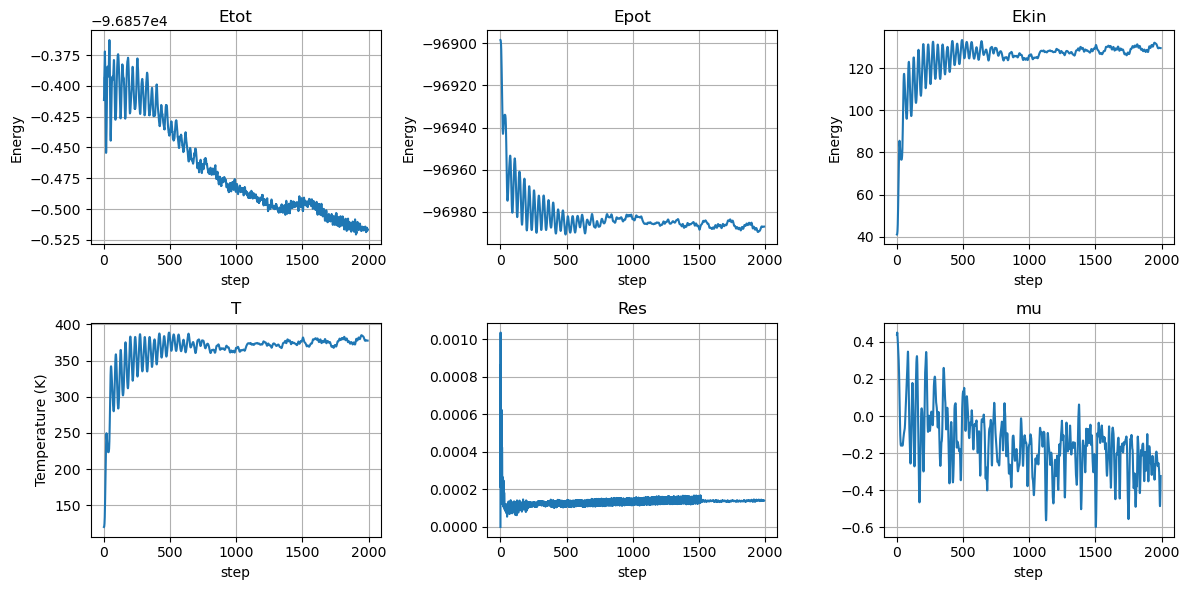

In [72]:
results = read_xyz_traj_data('solvated_trj.xyz')
# plot each entry in results as a subplot grid
keys = list(results.keys())[1:]
n = len(keys)

# x-axis: use 'step' if available
x = results.get('step', None)

cols = int(np.ceil(np.sqrt(n)))
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), squeeze=False)

for i, k in enumerate(keys):
	r, c = divmod(i, cols)
	ax = axes[r][c]
	y = results[k]

	if k == 'step' or x is None:
		ax.plot(np.arange(y.shape[0]), y, '-o', markersize=3)
		ax.set_xlabel('index')
	else:
		ax.plot(x, y, '-', markersize=3)
		ax.set_xlabel('step')

	ax.set_title(k)
	ax.grid(True)
	# optional nicer y-labels for energies/temperature
	if k.lower() in ('etot', 'epot', 'ekin'):
		ax.set_ylabel('Energy')
	if k.lower() == 't':
		ax.set_ylabel('Temperature (K)')

# turn off any unused subplots
for j in range(n, rows * cols):
	axes[j // cols][j % cols].axis('off')

plt.tight_layout()
plt.show()

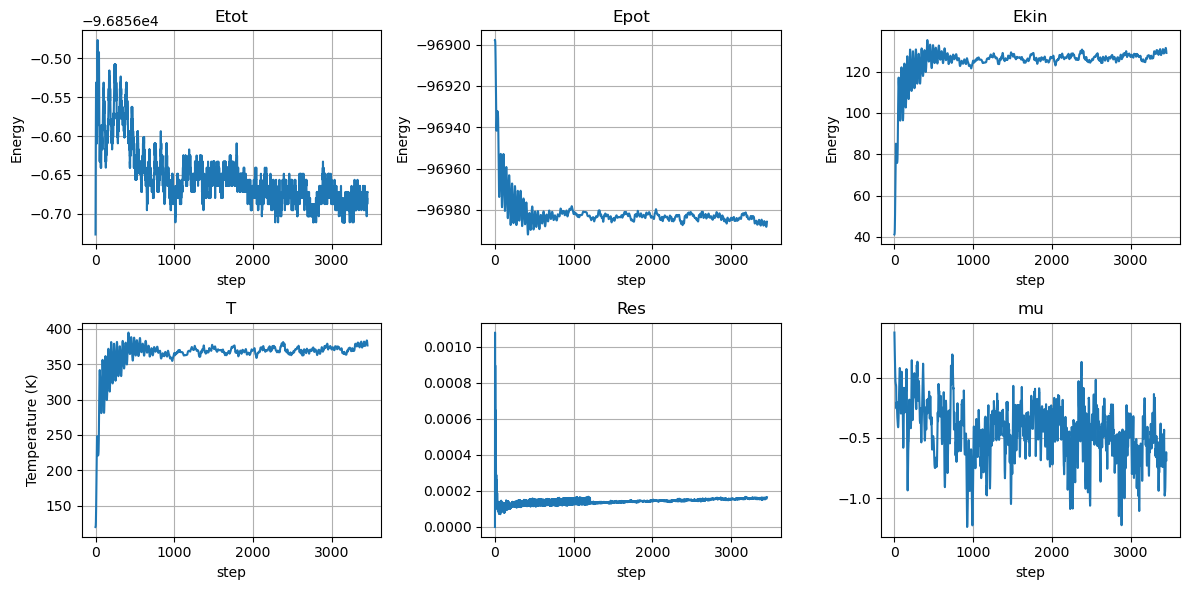

In [ ]:
results = read_xyz_traj_data('solvated_trj.xyz')
# plot each entry in results as a subplot grid
keys = list(results.keys())[1:]
n = len(keys)

# x-axis: use 'step' if available
x = results.get('step', None)

cols = int(np.ceil(np.sqrt(n)))
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), squeeze=False)

for i, k in enumerate(keys):
	r, c = divmod(i, cols)
	ax = axes[r][c]
	y = results[k]

	if k == 'step' or x is None:
		ax.plot(np.arange(y.shape[0]), y, '-o', markersize=3)
		ax.set_xlabel('index')
	else:
		ax.plot(x, y, '-', markersize=3)
		ax.set_xlabel('step')

	ax.set_title(k)
	ax.grid(True)
	# optional nicer y-labels for energies/temperature
	if k.lower() in ('etot', 'epot', 'ekin'):
		ax.set_ylabel('Energy')
	if k.lower() == 't':
		ax.set_ylabel('Temperature (K)')

# turn off any unused subplots
for j in range(n, rows * cols):
	axes[j // cols][j % cols].axis('off')

plt.tight_layout()
plt.show()

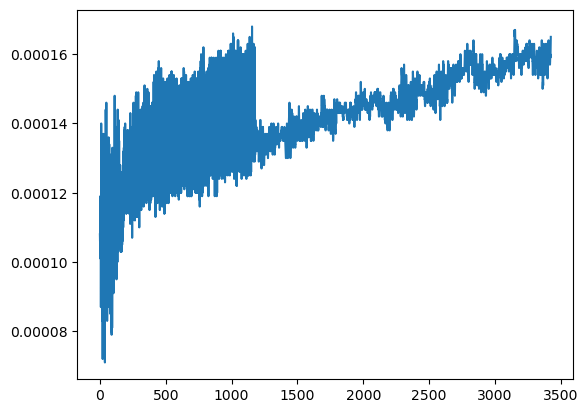

In [61]:
plt.plot(results['Res'][30:], '-', markersize=3)

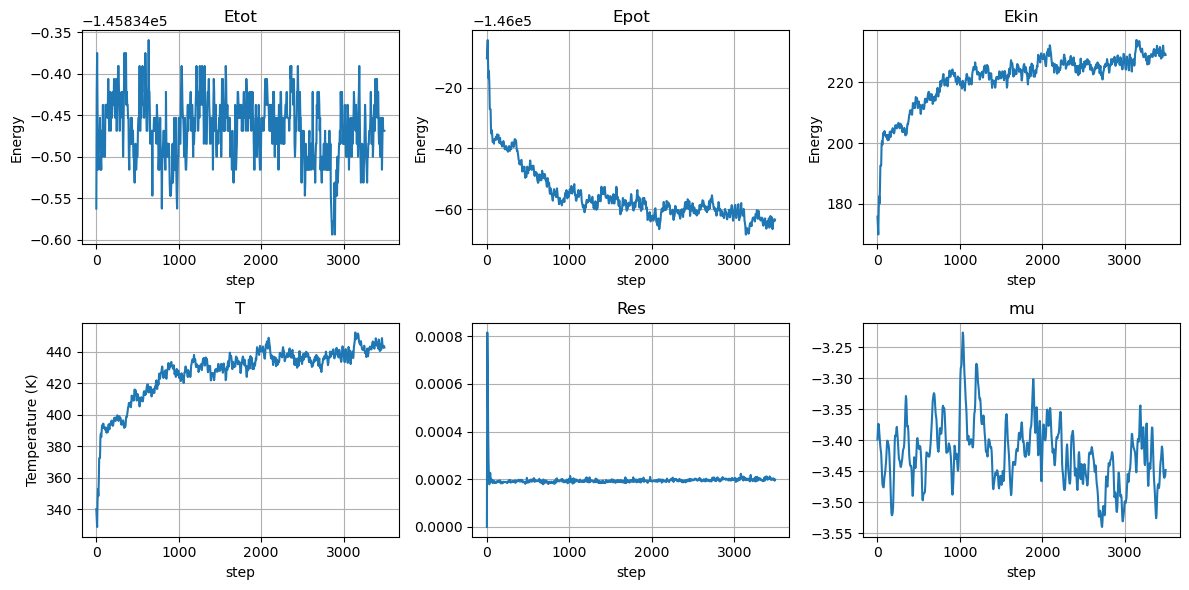

In [5]:
results = read_xyz_traj_data('solvated_ac_4k_rel_TRJ.xyz')
# plot each entry in results as a subplot grid
keys = list(results.keys())[1:]
n = len(keys)

# x-axis: use 'step' if available
x = results.get('step', None)

cols = int(np.ceil(np.sqrt(n)))
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), squeeze=False)

for i, k in enumerate(keys):
	r, c = divmod(i, cols)
	ax = axes[r][c]
	y = results[k]

	if k == 'step' or x is None:
		ax.plot(np.arange(y.shape[0]), y, '-o', markersize=3)
		ax.set_xlabel('index')
	else:
		ax.plot(x, y, '-', markersize=3)
		ax.set_xlabel('step')

	ax.set_title(k)
	ax.grid(True)
	# optional nicer y-labels for energies/temperature
	if k.lower() in ('etot', 'epot', 'ekin'):
		ax.set_ylabel('Energy')
	if k.lower() == 't':
		ax.set_ylabel('Temperature (K)')

# turn off any unused subplots
for j in range(n, rows * cols):
	axes[j // cols][j % cols].axis('off')

plt.tight_layout()
plt.show()